# Stable Diffusion
# Experimenting with Text to Image Generation

In this notebook, we'll experiment with generative AI using a text-to-image model called stable diffusion.  We'll be using an open source [model](https://huggingface.co/runwayml/stable-diffusion-2-1) from [Huggingface](huggingface.co)

## Setup

### Install Libraries

We need some libraries to run the diffusion pipeline.
The most important is the [Huggingface Diffusers library](https://huggingface.co/docs/diffusers/index), and we'll need also PyTORCH and boto3

- The diffusers library will allow us to load and run a Stable Diffusion Pipeline
- The Hugging Face library is needed to interact with the HF Model Hub and download checkpoints for local usage
- The boto3 library is needed to interact with remote S3 buckets

In [1]:
!pip install -U pip
!pip install -r requirements_experimentation.txt
!pip list | grep -E "torch|diffusers|transformers|accelerate"

accelerate                      0.31.0
diffusers                       0.30.0.dev0
torch                           2.3.0
torchvision                     0.14.1
transformers                    4.41.2


## Library Import

Now we load all required libraries to be used in the demo code

In [2]:
import os, random
try:
    import torch
    import torch.cuda as tc
    from diffusers import DiffusionPipeline
except Exception as e:
    print(f"Caught Exception: {e}")

/opt/app-root/lib64/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


### Check GPU

While we can run these notebooks without a GPU, it'll be much faster with one.  Let's check to make sure we have a GPU and how much memory we have available.

In [3]:
accelerator = "cpu"
print(f"Checking for the availability of a GPU...")
if tc.is_available():
    device_name = tc.get_device_name()
    device_capabilities = tc.get_device_capability()
    device_available_mem, device_total_mem = [x / 1024**3 for x in tc.mem_get_info()]
    print(f"A GPU is available! [{device_name} - {device_capabilities} - {device_available_mem}/{device_total_mem} GB VRAM]")
    accelerator = "cuda"

print(f"Using accelerator: {accelerator}")

Checking for the availability of a GPU...
A GPU is available! [Tesla V100-SXM2-16GB - (7, 0) - 15.4710693359375/15.7725830078125 GB VRAM]
Using accelerator: cuda


## Load the Pre-Trained Model

We now can load a pre-trained model directly from Huggingface.
Here we're specifying [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1), but we could also have used any number of models including [runwayml/stable-diffusion-v1-5](runwayml/stable-diffusion-v1-5) or [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4).

Fine tuned models are also a good choice ([DreamShaper](https://huggingface.co/Lykon/DreamShaper) for example)

The diffusers library allows to load a checkpoint directly from an Hugging Face repository name, like this: 
```
pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1")
```
or otherwise load a finetuned version of a diffusion model (i.e. local weights) directly from the filesystem:
```
pipeline = DiffusionPipeline.from_pretrained("./notebook-output/stable_diffusion_weights/redhat-dog")
```

There is also support for safetensors encoded checkpoint bundles.

In [4]:
# load the model from Huggingface
pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype = torch.float16)

# move the pipeline to the accelerator device
device = torch.device(accelerator)
pipeline.to(device)

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /opt/app-root/src/.cache/huggingface/hub/models--Lykon--DreamShaper/snapshots/228d79cb20811466f5c5710aa91f05dabd0b8a14/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /opt/app-root/src/.cache/huggingface/hub/models--Lykon--DreamShaper/snapshots/228d79cb20811466f5c5710aa91f05dabd0b8a14/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /opt/app-root/src/.cache/huggingface/hub/models--Lykon--DreamShaper/snapshots/228d79cb20811466f5c5710aa91f05dabd0b8a14/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /opt/app-root/src/.cache/huggingface/hub/models--Lykon--DreamShaper/snapshots/228d79cb20811466f5c5710aa91f05dabd0b8a14/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/opt/app-root/lib64/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.p

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.30.0.dev0",
  "_name_or_path": "Lykon/DreamShaper",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Sample Inference

The model is now loaded into the CPU or GPU: we can test it by performing an inference operation.
Let's try with the image of a dog:

In [5]:
# define prompts:
# this is the positive prompt, we declare what we want to get from the model
positive = "a photo of a dog"
# this is the negative prompt. Strictly not mandatory, we can use this to
# specify things that we do *not* want in the final image
negative = "ugly, deformed, bad_anatomy"
# guidance scale
cfg = 3.5
# seed bit length
bit_length = 64
# generation steps
steps = 30
# image width & height
img_size = { 'w': 512, 'h': 512}

# randomize seed for reproducibility or get a random image at each inference
random_seed = True

In [6]:
# generate a random seed for the torch generator
seed = random.getrandbits(bit_length)

# create a generator object with the custom seed value
torch_gen = torch.Generator(accelerator).manual_seed(seed)
print(f"Generating with seed: {torch_gen.seed()}")

# call the model via diffusers pipeline
gen_tensors = pipeline(prompt=positive,
                       negative_prompt=negative,
                       guidance_scale=cfg,
                       generator=torch_gen,
                       width=img_size.get('w'),
                       height=img_size.get('h'),
                       num_inference_steps=steps)

Generating with seed: 3422420164198803


  0%|          | 0/30 [00:00<?, ?it/s]

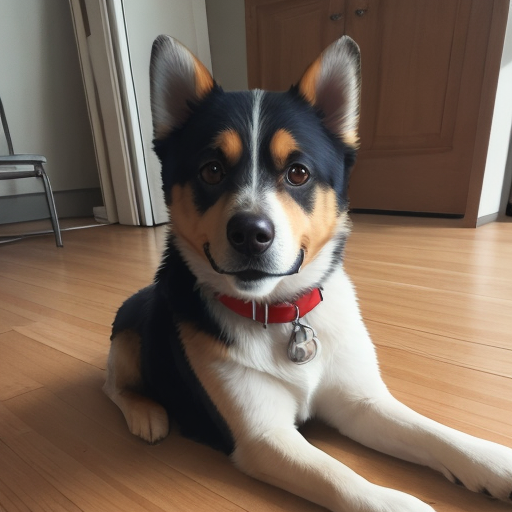

In [7]:
# extract the image
img = gen_tensors.images[0]

# display
img

### Tha is Not My Dog

The generated image  correctly shows a dog, but I'd like to have a photo of a *specific* dog: I know of a specific dog I want to generate pictures of.

This is my `rhteddy` dog:

![redhat dog](https://rhods-public.s3.amazonaws.com/sample-data/images/redhat-dog-small.jpg)

Let's try and generate a picture of Red Hat Teddy.

In [8]:
# run inference with a more specific prompt
prompt = "a photo of a rhteddy dog"

# create a generator object with the custom seed value
# for reproducibility: reuse last seed
if random_seed:
    seed = random.getrandbits(bit_length)

torch_gen = torch.Generator(accelerator).manual_seed(seed)
print(f"Generating with seed: {torch_gen.seed()}")

# call the model via diffusers pipeline
gen_tensors = pipeline(prompt=positive,
                       negative_prompt=negative,
                       guidance_scale=cfg,
                       generator=torch_gen,
                       width=img_size.get('w'),
                       height=img_size.get('h'),
                       num_inference_steps=steps)

Generating with seed: 25431209512415


  0%|          | 0/30 [00:00<?, ?it/s]

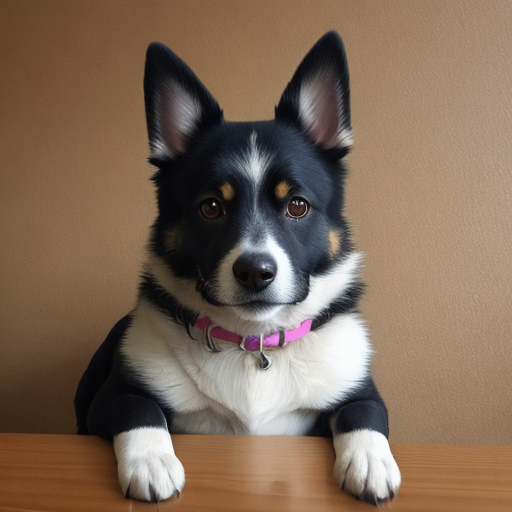

In [9]:
# extract the image
img = gen_tensors.images[0]

# display
img

### Still Not My Dog

As you can tell, we generated a picture, but it wasn't the *expected* dog. Moreover, with a constant seed we got the *same* dog as before, as expected.

This is because word `rhteddy`, means nothing to the CLIP model, or to you, either.  In order to teach the model about Teddy, I'll have to fine tune it
